# Import Libraries and Configure GPU

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
import re
import logging
from tqdm import tqdm


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Preventing memory growth issues
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Using the first available GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU detected and will be used for training.")
        print("Available GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Training will be performed on CPU.")


No GPU found. Training will be performed on CPU.


# Data Loading Functions

In [2]:
def load_processed_data(folder_path):
    """
    Load all processed Excel files from a given folder and combine them into a single DataFrame.
    """
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder {folder_path} does not exist.")

    # Get list of all Excel files in the folder
    files = [file for file in os.listdir(folder_path) if file.endswith('.xlsx')]

    if not files:
        raise ValueError(f"No Excel files found in the folder: {folder_path}")

    # Initialize an empty list to store individual DataFrames
    dataframes = []

    # Read each Excel file and append to the list
    for file in files:
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_excel(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

    # Concatenate all DataFrames into a single DataFrame
    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"Loaded {len(files)} files with a total of {combined_df.shape[0]} rows.")
        return combined_df
    else:
        raise ValueError("No valid data could be loaded from the folder.")

def load_all_folders(folder_paths):
    """
    Load processed data from multiple folders and combine them into a single DataFrame.
    """
    all_dataframes = []

    for folder_path in folder_paths:
        try:
            print(f"Loading data from folder: {folder_path}")
            df = load_processed_data(folder_path)
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error loading data from folder {folder_path}: {e}")

    # Concatenate all DataFrames from the folders
    if all_dataframes:
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"Total combined data shape: {combined_df.shape}")
        return combined_df
    else:
        raise ValueError("No valid data could be loaded from the provided folders.")

# Data Processing and Normalization

In [3]:
# Define the sequence length
sequence_length = 30  # Number of points for calculating moving average and integral

# List of training folder paths
train_data_folders = [
    "D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0030/csv/combined/changed",
    # "/mnt/60FE87C2FE878F4A/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/5. Battery Data Set/B0031/csv/combined/changed",
    # "/mnt/60FE87C2FE878F4A/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/5. Battery Data Set/B0032/csv/combined/changed"
]

# List of testing folder paths
test_data_folders = [
    "D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0029/csv/combined/changed",
]

# Load train and test data from multiple folders
try:
    train_data = load_all_folders(train_data_folders)
    test_data = load_all_folders(test_data_folders)
    print("Train and test data successfully loaded.")
except Exception as e:
    print(f"Error loading data: {e}")

# Define features and target variable
features = [
    'Voltage_measured (Volts)',
    'Current_measured (Amps)',
    # 'Integrated_Current_Window',
    # 'Moving_Average_Voltage',
    # 'Moving_Average_Current',
    # 'Moving_Average_Integrated_Current'
]

target = 'Temperature_measured (C)'

test_original_data = test_data.copy()

# Normalize the data
print("\nNormalizing Data...")
scaler = StandardScaler()
try:
    train_data[features + [target]] = scaler.fit_transform(train_data[features + [target]])
    test_data[features + [target]] = scaler.transform(test_data[features + [target]])
    print("Data normalization complete.")
except Exception as e:
    print(f"Error during normalization: {e}")
    raise


# Reset index after concatenation
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

Loading data from folder: D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0030/csv/combined/changed
Loaded 16 files with a total of 109559 rows.
Total combined data shape: (109559, 11)
Loading data from folder: D:/Uni/Master's/Term1/Fault-Tolerant System Design/Assignments/Replication/code/Dataset1/PCnnLstm/NASA/dataset/5. Battery Data Set/B0029/csv/combined/changed
Loaded 16 files with a total of 109559 rows.
Total combined data shape: (109559, 11)
Train and test data successfully loaded.

Normalizing Data...
Data normalization complete.


# Sequence Creation and Dataset Preparation

In [4]:
# Function to create sequences from data
def create_sequences(data, features, target, sequence_length):
    """
    Creates sequences of data for model training/testing.
    """
    X, y = [], []
    source_files = []
    for i in tqdm(range(len(data) - sequence_length), desc="Creating Sequences", unit="sequence"):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])
        source_files.append(data["Source_File"].iloc[i + sequence_length])
    return np.array(X), np.array(y), np.array(source_files)


def create_sequences_original(data, features, sequence_length):
    """
    Creates sequences of raw data for testing (no normalization applied).
    """
    X, y = [], []
    for i in tqdm(range(len(data) - sequence_length), desc="Creating Sequences", unit="sequence"):
        X.append(data[features].iloc[i:i + sequence_length].values)
        y.append(data[target].iloc[i + sequence_length])

    return np.array(X), np.array(y)


# Function to create sequences and save/load them
def prepare_sequences(data, features, target, sequence_length, dataset_type='train'):
    """
    Prepares sequences for model training or testing.
    """
    X, y, source_files = create_sequences(data, features, target, sequence_length)
    # Save the data for later use
    np.save(f'../npy_files/X_{dataset_type}.npy', X)
    np.save(f'../npy_files/y_{dataset_type}.npy', y)
    np.save(f'../npy_files/source_files_{dataset_type}.npy', source_files)
    print(f"{dataset_type.capitalize()} sequences created and saved.")
    return X, y, source_files

# Prepare training sequences
print("\nPreparing Training Sequences...")
if os.path.exists('../npy_files/X_train.npy') and os.path.exists('../npy_files/y_train.npy'):
    print("Loading train data from files...")
    X_train = np.load('../npy_files/X_train.npy')
    y_train = np.load('../npy_files/y_train.npy')
    source_files_train = np.load('../npy_files/source_files_train.npy')
else:
    X_train, y_train, source_files_train = prepare_sequences(train_data, features, target, sequence_length, dataset_type='train')

# Prepare testing sequences
print("\nPreparing Testing Sequences...")
if os.path.exists('../npy_files/X_test.npy') and os.path.exists('../npy_files/y_test.npy'):
    print("Loading test data from files...")
    X_test = np.load('../npy_files/X_test.npy')
    y_test = np.load('../npy_files/y_test.npy')
    source_files_test = np.load('../npy_files/source_files_test.npy')
else:
    X_test, y_test, source_files_test = prepare_sequences(test_data, features, target, sequence_length, dataset_type='test')


print("\nPreparing Original Testing Sequences...")
if os.path.exists('../npy_files/X_test_original.npy') and os.path.exists('../npy_files/y_test_original.npy'):
    print("Loading original test data from files...")
    X_test_original = np.load('../npy_files/X_test_original.npy')
    y_test_original = np.load('../npy_files/y_test_original.npy')
else:
    X_test_original, y_test_original = create_sequences_original(test_original_data, features, sequence_length)
    np.save('../npy_files/X_test_original.npy', X_test_original)
    np.save('../npy_files/y_test_original.npy', y_test_original)

# Create TensorFlow datasets
print("\nCreating TensorFlow Datasets...")
batch_size = 32

print(len(X_train))
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

print("Training and testing datasets are ready for modeling.")


Preparing Training Sequences...
Loading train data from files...

Preparing Testing Sequences...
Loading test data from files...

Preparing Original Testing Sequences...
Loading original test data from files...

Creating TensorFlow Datasets...
328647
Training and testing datasets are ready for modeling.


# PCNN-LSTM Model Definition

In [5]:
# Define the model architecture
def build_pcnn_lstm_model(input_shape, output_size=1):
    inputs = layers.Input(shape=input_shape)  # (seq_len, input_size)

    # CNN Branch
    x_cnn = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(inputs)
    x_cnn = layers.BatchNormalization()(x_cnn)
    x_cnn = layers.MaxPooling1D(pool_size=2, strides=1)(x_cnn)
    x_cnn = layers.Flatten()(x_cnn)  # (batch_size, features)

    # LSTM Branch
    x_lstm = layers.LSTM(200, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', unroll=True)(inputs)
    x_lstm = layers.BatchNormalization()(x_lstm)
    x_lstm = layers.LSTM(100, activation='tanh', recurrent_activation='sigmoid', unroll=True)(x_lstm)

    # Concatenate CNN and LSTM branches
    x = layers.concatenate([x_cnn, x_lstm])  # Flatten already handled

    # Fully Connected Layers
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(output_size)(x)  # For regression

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (sequence_length, len(features))
output_size = 1  # For regression

model = build_pcnn_lstm_model(input_shape)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28, 16)    │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 16)    │         64 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 200)   │    162,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 27, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 200)   │        800 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 432)       │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │    120,400 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 532)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200)       │    106,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     20,100 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 100)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │     10,100 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        101 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 420,677 (1.60 MB)

 Trainable params: 420,245 (1.60 MB)

 Non-trainable params: 432 (1.69 KB)

# Model Training and Callbacks

In [6]:
# Configure logging to output to both console and file
logging.basicConfig(
    level=logging.INFO,
    format='%(message)s',
    handlers=[
        logging.FileHandler("./PCnnLstm_training_log.txt"),  # Save output to file
        logging.StreamHandler()  # Also display output in console
    ]
)
logger = logging.getLogger()

# File to save the last epoch
last_epoch_file = "./last_epoch.txt"

# Custom callback to log detailed epoch information
class LoggingCallback(callbacks.Callback):
    def on_train_begin(self, logs=None):
        logger.info("Training started.")

    def on_epoch_end(self, epoch, logs=None):
        if logs:
            log_message = f"Epoch {epoch + 1}/{self.params['epochs']} completed."
            for key, value in logs.items():
                log_message += f" - {key}: {value:.4f}"
            logger.info(log_message)
        else:
            logger.info(f"Epoch {epoch + 1}/{self.params['epochs']} completed.")
        logger.info("\n")
    def on_train_end(self, logs=None):
        logger.info("Training completed.")

# Custom callback to log saving model
class CustomModelCheckpoint(callbacks.ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        if logs and self.best == logs.get('loss'):
            logger.info(
                f"Epoch {epoch + 1}: loss improved to {logs['loss']:.4f}, saving model to {self.filepath}."
            )
            # Save the last completed epoch
            with open(last_epoch_file, "w") as f:
                f.write(str(epoch + 1))  # Save the next epoch to start from

# Load checkpoint if exists
checkpoint_path = "./PCnnLstm_checkpoint.keras"
initial_epoch = 0
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    logger.info("Checkpoint loaded. Resuming training...")
    if os.path.exists(last_epoch_file):
        with open(last_epoch_file, "r") as f:
            initial_epoch = int(f.read().strip())
        logger.info(f"Resuming training from epoch {initial_epoch}.")
else:
    logger.warning("No checkpoint found. Training will start from scratch.")

# Initialize callbacks
checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping_callback = callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=30,
    initial_epoch=initial_epoch,  # Start from the last saved epoch
    callbacks=[checkpoint_callback, early_stopping_callback, LoggingCallback()],
    verbose=1
)

# Log the final history
logger.info("Final Training History:")
for key, values in history.history.items():
    logger.info(f"{key}: {values}")


No checkpoint found. Training will start from scratch.
Training started.


Epoch 1/30


I0000 00:00:1736114410.407762    6962 service.cc:148] XLA service 0x7388fc012f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736114410.407784    6962 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-01-06 01:30:10.611697: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736114412.444430    6962 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-06 01:30:18.823018: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  17/1202 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1.0802 - mae: 0.6680 - rmse: 1.0368

I0000 00:00:1736114424.591224    6962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3476 - mae: 0.3028 - rmse: 0.5772
Epoch 1: loss improved from inf to 0.22016, saving model to ./PCnnLstm_checkpoint.keras


Epoch 1: loss improved to 0.2202, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 1/30 completed. - loss: 0.2202 - mae: 0.2331 - rmse: 0.4692




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 46s 20ms/step - loss: 0.3475 - mae: 0.3027 - rmse: 0.5771
Epoch 2/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1161 - mae: 0.1701 - rmse: 0.3404
Epoch 2: loss improved from 0.22016 to 0.11758, saving model to ./PCnnLstm_checkpoint.keras


Epoch 2: loss improved to 0.1176, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 2/30 completed. - loss: 0.1176 - mae: 0.1704 - rmse: 0.3429




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1161 - mae: 0.1701 - rmse: 0.3404
Epoch 3/30
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0928 - mae: 0.1555 - rmse: 0.3044
Epoch 3: loss improved from 0.11758 to 0.09729, saving model to ./PCnnLstm_checkpoint.keras


Epoch 3: loss improved to 0.0973, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 3/30 completed. - loss: 0.0973 - mae: 0.1572 - rmse: 0.3119




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0928 - mae: 0.1555 - rmse: 0.3044
Epoch 4/30
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0833 - mae: 0.1507 - rmse: 0.2885
Epoch 4: loss improved from 0.09729 to 0.08898, saving model to ./PCnnLstm_checkpoint.keras


Epoch 4: loss improved to 0.0890, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 4/30 completed. - loss: 0.0890 - mae: 0.1525 - rmse: 0.2983




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0833 - mae: 0.1507 - rmse: 0.2885
Epoch 5/30
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0801 - mae: 0.1459 - rmse: 0.2829
Epoch 5: loss improved from 0.08898 to 0.08035, saving model to ./PCnnLstm_checkpoint.keras


Epoch 5: loss improved to 0.0803, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 5/30 completed. - loss: 0.0803 - mae: 0.1466 - rmse: 0.2835




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0801 - mae: 0.1459 - rmse: 0.2829
Epoch 6/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0778 - mae: 0.1432 - rmse: 0.2789
Epoch 6: loss did not improve from 0.08035


Epoch 6/30 completed. - loss: 0.0816 - mae: 0.1453 - rmse: 0.2856




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0779 - mae: 0.1432 - rmse: 0.2789
Epoch 7/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0724 - mae: 0.1404 - rmse: 0.2688
Epoch 7: loss improved from 0.08035 to 0.07693, saving model to ./PCnnLstm_checkpoint.keras


Epoch 7: loss improved to 0.0769, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 7/30 completed. - loss: 0.0769 - mae: 0.1421 - rmse: 0.2774




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0724 - mae: 0.1404 - rmse: 0.2688
Epoch 8/30
1194/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0601 - mae: 0.1322 - rmse: 0.2448
Epoch 8: loss improved from 0.07693 to 0.06624, saving model to ./PCnnLstm_checkpoint.keras


Epoch 8: loss improved to 0.0662, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 8/30 completed. - loss: 0.0662 - mae: 0.1357 - rmse: 0.2574




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0601 - mae: 0.1323 - rmse: 0.2449
Epoch 9/30
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0627 - mae: 0.1366 - rmse: 0.2502
Epoch 9: loss did not improve from 0.06624


Epoch 9/30 completed. - loss: 0.0663 - mae: 0.1367 - rmse: 0.2574




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0627 - mae: 0.1366 - rmse: 0.2502
Epoch 10/30
1199/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0623 - mae: 0.1349 - rmse: 0.2494
Epoch 10: loss improved from 0.06624 to 0.06426, saving model to ./PCnnLstm_checkpoint.keras


Epoch 10: loss improved to 0.0643, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 10/30 completed. - loss: 0.0643 - mae: 0.1359 - rmse: 0.2535




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0623 - mae: 0.1349 - rmse: 0.2494
Epoch 11/30
1201/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0546 - mae: 0.1280 - rmse: 0.2333
Epoch 11: loss improved from 0.06426 to 0.05987, saving model to ./PCnnLstm_checkpoint.keras


Epoch 11: loss improved to 0.0599, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 11/30 completed. - loss: 0.0599 - mae: 0.1300 - rmse: 0.2447




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0546 - mae: 0.1281 - rmse: 0.2333
Epoch 12/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0530 - mae: 0.1263 - rmse: 0.2299
Epoch 12: loss improved from 0.05987 to 0.05803, saving model to ./PCnnLstm_checkpoint.keras


Epoch 12: loss improved to 0.0580, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 12/30 completed. - loss: 0.0580 - mae: 0.1293 - rmse: 0.2409




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0530 - mae: 0.1263 - rmse: 0.2299
Epoch 13/30
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0555 - mae: 0.1310 - rmse: 0.2355
Epoch 13: loss did not improve from 0.05803


Epoch 13/30 completed. - loss: 0.0587 - mae: 0.1311 - rmse: 0.2423




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0555 - mae: 0.1310 - rmse: 0.2355
Epoch 14/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0517 - mae: 0.1259 - rmse: 0.2273
Epoch 14: loss improved from 0.05803 to 0.05267, saving model to ./PCnnLstm_checkpoint.keras


Epoch 14: loss improved to 0.0527, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 14/30 completed. - loss: 0.0527 - mae: 0.1254 - rmse: 0.2295




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0517 - mae: 0.1259 - rmse: 0.2273
Epoch 15/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - mae: 0.1244 - rmse: 0.2232
Epoch 15: loss did not improve from 0.05267


Epoch 15/30 completed. - loss: 0.0531 - mae: 0.1255 - rmse: 0.2303




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0499 - mae: 0.1244 - rmse: 0.2233
Epoch 16/30
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0470 - mae: 0.1215 - rmse: 0.2167
Epoch 16: loss improved from 0.05267 to 0.05011, saving model to ./PCnnLstm_checkpoint.keras


Epoch 16: loss improved to 0.0501, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 16/30 completed. - loss: 0.0501 - mae: 0.1225 - rmse: 0.2239




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0470 - mae: 0.1215 - rmse: 0.2168
Epoch 17/30
1194/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0457 - mae: 0.1189 - rmse: 0.2136
Epoch 17: loss improved from 0.05011 to 0.04793, saving model to ./PCnnLstm_checkpoint.keras


Epoch 17: loss improved to 0.0479, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 17/30 completed. - loss: 0.0479 - mae: 0.1199 - rmse: 0.2189




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0457 - mae: 0.1189 - rmse: 0.2136
Epoch 18/30
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0442 - mae: 0.1188 - rmse: 0.2101
Epoch 18: loss did not improve from 0.04793


Epoch 18/30 completed. - loss: 0.0493 - mae: 0.1212 - rmse: 0.2221




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0443 - mae: 0.1188 - rmse: 0.2101
Epoch 19/30
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0499 - mae: 0.1223 - rmse: 0.2230
Epoch 19: loss did not improve from 0.04793


Epoch 19/30 completed. - loss: 0.0501 - mae: 0.1216 - rmse: 0.2239




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0499 - mae: 0.1222 - rmse: 0.2230
Epoch 20/30
1198/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0464 - mae: 0.1190 - rmse: 0.2152
Epoch 20: loss did not improve from 0.04793


Epoch 20/30 completed. - loss: 0.0496 - mae: 0.1220 - rmse: 0.2226




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0464 - mae: 0.1191 - rmse: 0.2152
Epoch 21/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0441 - mae: 0.1177 - rmse: 0.2096
Epoch 21: loss improved from 0.04793 to 0.04748, saving model to ./PCnnLstm_checkpoint.keras


Epoch 21: loss improved to 0.0475, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 21/30 completed. - loss: 0.0475 - mae: 0.1200 - rmse: 0.2179




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0441 - mae: 0.1177 - rmse: 0.2096
Epoch 22/30
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0484 - mae: 0.1209 - rmse: 0.2198
Epoch 22: loss did not improve from 0.04748


Epoch 22/30 completed. - loss: 0.0501 - mae: 0.1215 - rmse: 0.2238




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0484 - mae: 0.1209 - rmse: 0.2198
Epoch 23/30
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0437 - mae: 0.1188 - rmse: 0.2089
Epoch 23: loss improved from 0.04748 to 0.04705, saving model to ./PCnnLstm_checkpoint.keras


Epoch 23: loss improved to 0.0471, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 23/30 completed. - loss: 0.0471 - mae: 0.1203 - rmse: 0.2169




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0437 - mae: 0.1188 - rmse: 0.2090
Epoch 24/30
1194/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0448 - mae: 0.1185 - rmse: 0.2115
Epoch 24: loss improved from 0.04705 to 0.04695, saving model to ./PCnnLstm_checkpoint.keras


Epoch 24: loss improved to 0.0470, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 24/30 completed. - loss: 0.0470 - mae: 0.1192 - rmse: 0.2167




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0448 - mae: 0.1185 - rmse: 0.2115
Epoch 25/30
1196/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0443 - mae: 0.1179 - rmse: 0.2104
Epoch 25: loss improved from 0.04695 to 0.04676, saving model to ./PCnnLstm_checkpoint.keras


Epoch 25: loss improved to 0.0468, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 25/30 completed. - loss: 0.0468 - mae: 0.1188 - rmse: 0.2162




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0444 - mae: 0.1179 - rmse: 0.2105
Epoch 26/30
1195/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0419 - mae: 0.1148 - rmse: 0.2044
Epoch 26: loss did not improve from 0.04676


Epoch 26/30 completed. - loss: 0.0474 - mae: 0.1178 - rmse: 0.2177




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0419 - mae: 0.1148 - rmse: 0.2045
Epoch 27/30
1200/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0418 - mae: 0.1146 - rmse: 0.2042
Epoch 27: loss improved from 0.04676 to 0.04588, saving model to ./PCnnLstm_checkpoint.keras


Epoch 27: loss improved to 0.0459, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 27/30 completed. - loss: 0.0459 - mae: 0.1171 - rmse: 0.2142




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0418 - mae: 0.1146 - rmse: 0.2042
Epoch 28/30
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0447 - mae: 0.1185 - rmse: 0.2114
Epoch 28: loss improved from 0.04588 to 0.04487, saving model to ./PCnnLstm_checkpoint.keras


Epoch 28: loss improved to 0.0449, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 28/30 completed. - loss: 0.0449 - mae: 0.1170 - rmse: 0.2118




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0447 - mae: 0.1185 - rmse: 0.2114
Epoch 29/30
1194/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0452 - mae: 0.1167 - rmse: 0.2125
Epoch 29: loss did not improve from 0.04487


Epoch 29/30 completed. - loss: 0.0471 - mae: 0.1188 - rmse: 0.2170




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0452 - mae: 0.1167 - rmse: 0.2125
Epoch 30/30
1197/1202 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0422 - mae: 0.1159 - rmse: 0.2052
Epoch 30: loss improved from 0.04487 to 0.04438, saving model to ./PCnnLstm_checkpoint.keras


Epoch 30: loss improved to 0.0444, saving model to ./PCnnLstm_checkpoint.keras.
Epoch 30/30 completed. - loss: 0.0444 - mae: 0.1155 - rmse: 0.2107




1202/1202 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0422 - mae: 0.1159 - rmse: 0.2052
Restoring model weights from the end of the best epoch: 30.


Training completed.
Final Training History:
loss: [0.22015756368637085, 0.1175776794552803, 0.09729140996932983, 0.08897607028484344, 0.08034536242485046, 0.08155031502246857, 0.07693176716566086, 0.06623715162277222, 0.0662546306848526, 0.06425993144512177, 0.05987429991364479, 0.05803202837705612, 0.058687325567007065, 0.0526697039604187, 0.05305454134941101, 0.050109200179576874, 0.04793160781264305, 0.049306415021419525, 0.050125252455472946, 0.0495629720389843, 0.047482799738645554, 0.05009752884507179, 0.047054924070835114, 0.04695311561226845, 0.046759460121393204, 0.04737604781985283, 0.04588402435183525, 0.044867392629384995, 0.047109995037317276, 0.04437686875462532]
mae: [0.23314492404460907, 0.170432448387146, 0.15723052620887756, 0.1525256633758545, 0.1465604603290558, 0.14533007144927979, 0.1420791894197464, 0.13570719957351685, 0.13672389090061188, 0.13588598370552063, 0.12997028231620789, 0.12930068373680115, 0.13108719885349274, 0.12538166344165802, 0.1255028396844864,

# ESP32 Integration and Progress Tracking

In [6]:
import serial
import pickle

# Path to store progress
progress_file = "./progress_data.pkl"


# Load previous progress if available
if os.path.exists(progress_file):
    with open(progress_file, "rb") as f:
        progress_data = pickle.load(f)
        start_index = progress_data.get("last_index", 0)
        esp_preds_scaled = progress_data.get("esp_preds_scaled", [])
        model_preds_scaled = progress_data.get("model_preds_scaled", [])
        labels_scaled = progress_data.get("labels_scaled", [])
else:
    start_index = 0
    esp_preds_scaled = []
    model_preds_scaled = []
    labels_scaled = []

run_on_esp = False

if run_on_esp:
    # Serial connection settings for ESP32
    ESP32_PORT = "/dev/ttyACM0"  # Adjust based on your system
    BAUD_RATE = 115200
    esp = serial.Serial(ESP32_PORT, BAUD_RATE, timeout=5)

    # Process data
    for i, sequence in enumerate(tqdm(X_test[start_index:], desc="Processing Data", unit="sequence", initial=start_index, total=len(X_test))):
        index = i + start_index  # Adjust index relative to the full dataset

        # ===========================
        # 1) Model prediction in Python
        # ===========================
        sequence_expanded = np.expand_dims(sequence, axis=0)
        local_pred = model.predict(sequence_expanded, verbose=0)  # Shape: (1, 1)
        local_pred_val = local_pred[0, 0]  # Extract the predicted value (normalized scale)

        model_preds_scaled.append(local_pred_val)
        labels_scaled.append(y_test[index])  # Append the true value (normalized scale)

        # ===========================
        # 2) Send data to ESP32
        # ===========================
        flattened = sequence.flatten()
        payload = ",".join(map(str, flattened))
        max_retries = 3  # Maximum number of retries
        retries = 0
        esp_pred_val = np.nan  # Default value in case of failure

        while retries < max_retries:
            try:
                esp.write((payload + "\n").encode())

                raw_response = esp.readline()
                response = raw_response.decode().strip()
                match = re.search(r"Predicted Temperature:\s*(-?\d*\.\d+|-?\d+)", response)

                if match:
                    esp_pred_val = float(match.group(1))
                    break  # Exit the loop if successful
                else:
                    raise ValueError(f"No numeric value found in response: {response}")

            except Exception as e:
                retries += 1
                print(f"Error decoding ESP32 response for sample {index + 1}, attempt {retries}: {e}. Raw response: {raw_response}")

        if retries == max_retries:
            print(f"Failed to get valid response from ESP32 for sample {index + 1} after {max_retries} attempts.")
            
        esp_preds_scaled.append(esp_pred_val)

        # ===========================
        # Save progress
        # ===========================
        progress_data = {
            "last_index": index + 1,
            "esp_preds_scaled": esp_preds_scaled,
            "model_preds_scaled": model_preds_scaled,
            "labels_scaled": labels_scaled,
        }
        with open(progress_file, "wb") as f:
            pickle.dump(progress_data, f)

    # Close ESP32 connection
    esp.close()


# Output Creation, Comparison, and Visualization

Comparison file saved: ./result_1\Comparison_ESP32_vs_Model.xlsx


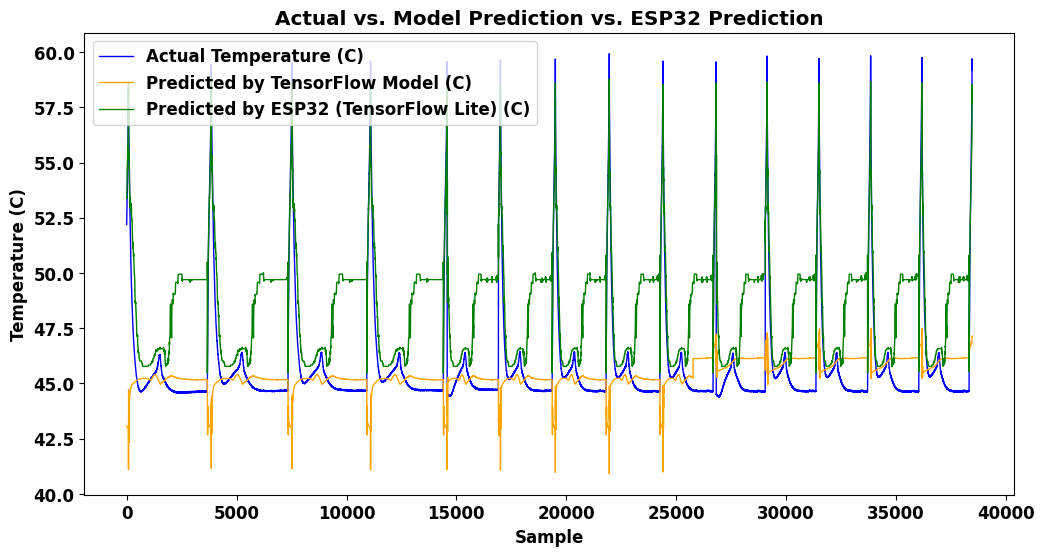

C:\Users\user\AppData\Local\Temp\ipykernel_9900\4219621860.py:113: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


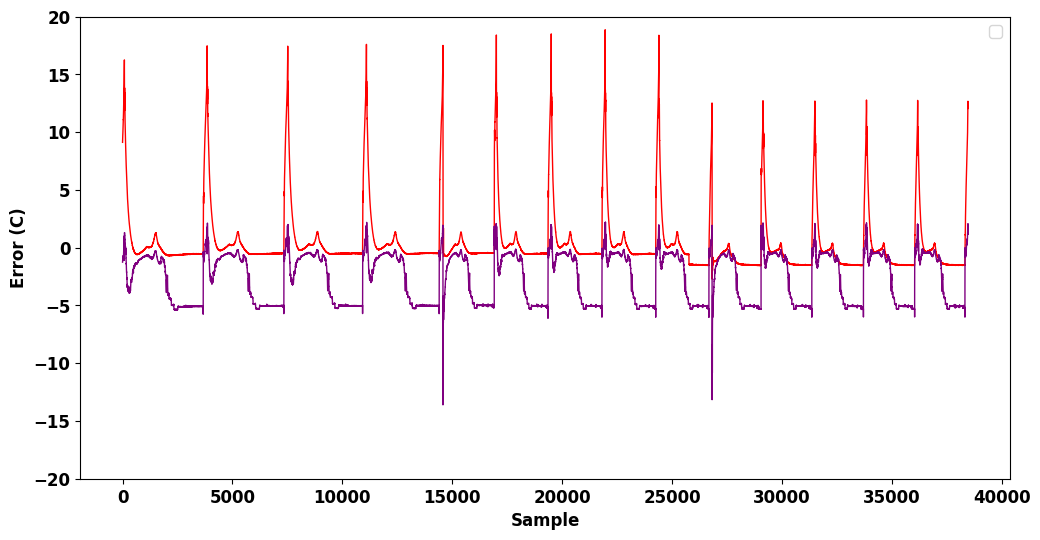

Model MAE: 1.43, RMSE: 2.91
ESP32 MAE: 2.73, RMSE: 3.43


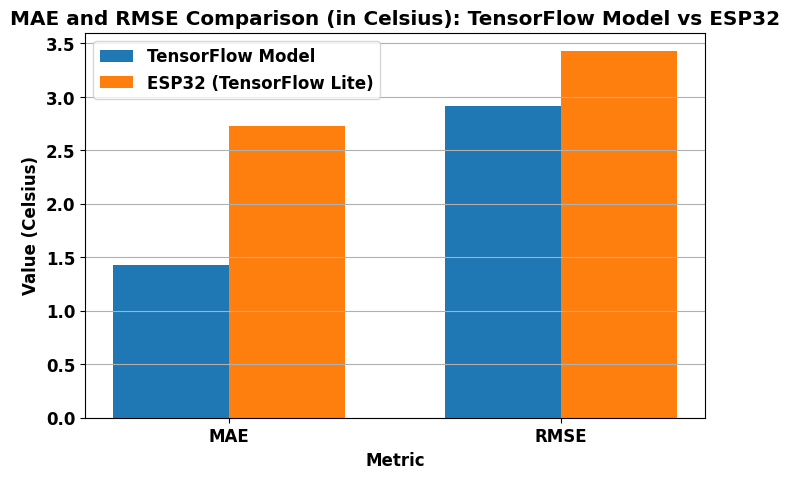

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------
# Matplotlib settings for high-quality images and bold text
# -------------------------
plt.rcParams['figure.dpi'] = 100  # DPI for preview
plt.rcParams['savefig.dpi'] = 1000  # DPI for saving figures (adjust if needed)
plt.rcParams['font.size'] = 12     # Default font size
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
# -------------------------

# Flag to create output files
create_outputs = True

if create_outputs:
    # Set the base output directory name and counter for results
    result_number = 1
    directory_name = f"./result_{result_number}"

    # Ensure the output directory exists
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Assume the following variables are pre-defined:
    # labels_scaled, model_preds_scaled, esp_preds_scaled, features, scaler

    # Reshape scaled labels and predictions into column vectors
    labels_scaled_arr = np.array(labels_scaled).reshape(-1, 1)
    model_preds_scaled_arr = np.array(model_preds_scaled).reshape(-1, 1)
    esp_preds_scaled_arr = np.array(esp_preds_scaled).reshape(-1, 1)

    # Create zero placeholders for feature inversion
    num_features = len(features)
    zeros_for_features = np.zeros((len(labels_scaled_arr), num_features))

    # Inverse transform to obtain original temperature values
    labels_original = scaler.inverse_transform(np.hstack([zeros_for_features, labels_scaled_arr]))[:, -1]
    model_preds_original = scaler.inverse_transform(np.hstack([zeros_for_features, model_preds_scaled_arr]))[:, -1]
    esp_preds_original = scaler.inverse_transform(np.hstack([zeros_for_features, esp_preds_scaled_arr]))[:, -1]

    # ==============================
    # Create a comparison DataFrame
    # ==============================
    comparison_df = pd.DataFrame({
        "Sample_Index": range(1, len(labels_original) + 1),
        "Actual (C)": labels_original,
        "Model_Pred (C)": model_preds_original,
        "ESP_Pred (C)": esp_preds_original,
    })

    # Compute absolute errors
    comparison_df["Error_Model"] = comparison_df["Actual (C)"] - comparison_df["Model_Pred (C)"]
    comparison_df["Error_ESP"] = comparison_df["Actual (C)"] - comparison_df["ESP_Pred (C)"]

    # Create flags for errors exceeding 5 degrees
    comparison_df["Error_Model>5"] = abs(comparison_df["Error_Model"]) > 5
    comparison_df["Error_ESP>5"] = abs(comparison_df["Error_ESP"]) > 5

    # ==============================
    # Save the comparison DataFrame to an Excel file
    # ==============================
    excel_file = os.path.join(directory_name, "Comparison_ESP32_vs_Model.xlsx")
    comparison_df.to_excel(excel_file, index=False)

    # Highlight rows where error exceeds 5 in the Excel file
    wb = load_workbook(excel_file)
    ws = wb.active
    red_fill = PatternFill(start_color="FF0000", end_color="FF0000", fill_type="solid")

    for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
        # The last two columns in the Excel file are "Error_Model>5" and "Error_ESP>5"
        if row[-2].value:  # If "Error_Model>5" is True
            row[-4].fill = red_fill  # Highlight "Error_Model"
        if row[-1].value:  # If "Error_ESP>5" is True
            row[-3].fill = red_fill  # Highlight "Error_ESP"

    wb.save(excel_file)
    print(f"Comparison file saved: {excel_file}")

    # ==============================
    # Plot temperature comparison
    # ==============================
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df["Actual (C)"], label="Actual Temperature (C)", color="blue", linewidth=1)
    plt.plot(comparison_df["Model_Pred (C)"], label="Predicted by TensorFlow Model (C)", color="orange", linewidth=1)
    plt.plot(comparison_df["ESP_Pred (C)"], label="Predicted by ESP32 (TensorFlow Lite) (C)", color="green", linewidth=1)
    plt.title("Actual vs. Model Prediction vs. ESP32 Prediction", fontweight='bold')
    plt.xlabel("Sample", fontweight='bold')
    plt.ylabel("Temperature (C)", fontweight='bold')
    plt.legend()
    plt.grid(False)

    plot_filename = os.path.join(directory_name, 'Actual_vs_Model_vs_ESP.png')
    plt.savefig(plot_filename, dpi=1000, format='png', bbox_inches='tight', pad_inches=0)
    plt.show()

    # Plot error comparison
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df["Error_Model"], color="red", linewidth=1)
    plt.plot(comparison_df["Error_ESP"], color="purple", linewidth=1)
    # plt.title("Error Comparison: TensorFlow Model vs. ESP32", fontweight='bold')
    plt.xlabel("Sample", fontweight='bold')
    plt.ylabel("Error (C)", fontweight='bold')
    plt.ylim(-20, 20)
    plt.legend()
    plt.grid(False)

    plot_filename = os.path.join(directory_name, 'Error_Model_vs_ESP.png')
    plt.savefig(plot_filename, dpi=1000, format='png', bbox_inches='tight', pad_inches=0)
    plt.show()

    # ==============================
    # Compute MAE and RMSE
    # ==============================
    comparison_df = comparison_df.dropna(subset=["Actual (C)", "ESP_Pred (C)", "Model_Pred (C)"])

    mae_model = mean_absolute_error(comparison_df["Actual (C)"], comparison_df["Model_Pred (C)"])
    rmse_model = np.sqrt(mean_squared_error(comparison_df["Actual (C)"], comparison_df["Model_Pred (C)"]))

    mae_esp = mean_absolute_error(comparison_df["Actual (C)"], comparison_df["ESP_Pred (C)"])
    rmse_esp = np.sqrt(mean_squared_error(comparison_df["Actual (C)"], comparison_df["ESP_Pred (C)"]))

    # Print results
    print(f"Model MAE: {mae_model:.2f}, RMSE: {rmse_model:.2f}")
    print(f"ESP32 MAE: {mae_esp:.2f}, RMSE: {rmse_esp:.2f}")

    # ==============================
    # Plot MAE and RMSE comparison
    # ==============================
    metrics_df = pd.DataFrame({
        "Metric": ["MAE", "RMSE"],
        "Model": [mae_model, rmse_model],
        "ESP32": [mae_esp, rmse_esp]
    })

    plt.figure(figsize=(8, 5))
    bar_width = 0.35
    index = np.arange(len(metrics_df))

    plt.bar(index, metrics_df["Model"], bar_width, label="TensorFlow Model")
    plt.bar(index + bar_width, metrics_df["ESP32"], bar_width, label="ESP32 (TensorFlow Lite)")

    plt.xlabel("Metric", fontweight='bold')
    plt.ylabel("Value (Celsius)", fontweight='bold')
    plt.title("MAE and RMSE Comparison (in Celsius): TensorFlow Model vs ESP32", fontweight='bold')
    plt.xticks(index + bar_width / 2, metrics_df["Metric"])
    plt.legend()
    plt.grid(True, axis='y')

    plot_filename = os.path.join(directory_name, 'MAE_RMSE_Comparison.png')
    plt.savefig(plot_filename, dpi=1000, format='png', bbox_inches='tight', pad_inches=0)
    plt.show()
